# Industry Accelerators - Insurance Loss Estimation Using Remote Sensing Data

## Model training and deployment 

### Contents
- [Introduction](#intro)
- [Functions](#functions)
- [Load Input Data](#loaddata)
- [User Inputs](#userinputs)
- [Data Preparation and Exploration](#dataprep)
- [Build Tranformers and Model Pipelines](#pipelines)
- [Hyper Parameter Tuning](#tuning)
- [Model Results](#results)
- [Create Deployment Space](#deploymentspace)
- [Save the model in Cloud Pak for Data and Deploy](#savemodel)
- [Sample Scoring](#samplescoring)

## Introduction <a name="intro"></a>
In `1 - Impact Region Analysis with Remote Sensing` notebook we have calculated the impact level of the flood on different properties in Cameron city, Louisiana. In this notebook we will combine the flood impact on the various properties with individual property and insurance details to predict the estimated claim amount.
<br>

We will go through the end-to-end process of importing the data, preparing the data, testing machine learning models, selecting the best performing model and deploying a pipeline. The model predicts the estimated insurance claim amount on a property based on the impact score, property damage amount, other property  and insurance details. We will use sklearn transformers and a pipeline to complete the steps of transforming the raw data and building a machine learning model, before deploying the pipeline using [Watson Machine Learning](https://pypi.org/project/ibm-watson-machine-learning).
<br>




Before executing this notebook on IBM Cloud, you need to:<br>
1) When you import this project on an IBM Cloud environment, insert a project access token at the top of this notebook as a code cell. <br>
If you do not see the cell above, Insert a project token: Click on **More -> Insert project token** in the top-right menu section and run the cell. <br>

![ws-project.mov](https://media.giphy.com/media/jSVxX2spqwWF9unYrs/giphy.gif)
2) Provide your IBM Cloud API key in the cell below.<br>
3) You can then step through the notebook execution cell by cell, by selecting Shift-Enter. Or you can execute the entire notebook by selecting **Cell -> Run All** from the menu.<br>


#### Insert IBM Cloud API key
Your Cloud API key can be generated by going to the <a href="https://cloud.ibm.com/iam/apikeys" target="_blank" rel="noopener noreferrer">API Keys section of the Cloud console</a>. From that page, scroll down to the API Keys section, and click Create an IBM Cloud API key. Give your key a name and click Create, then copy the created key and paste it below. 

If you are running this notebook on Cloud Pak For Data on-prem, leave the ibmcloud_api_key field blank.

In [2]:
ibmcloud_api_key = ''

In [3]:
try:
    project
except NameError:
    # READING AND WRITING PROJECT ASSETS
    import project_lib
    project = project_lib.Project() 


In the cell below, we import the python libraries that we will use throughout the notebook.

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn import metrics
import os
import sys
import seaborn as sns
sns.set(style='darkgrid',palette="deep")

from sklearn.model_selection import train_test_split
pd.set_option('display.float_format', lambda x: '%.2f' % x)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.compose import TransformedTargetRegressor




### Functions <a name="functions"></a>
The following cell contains a function which generates a number of plots which are used for some preliminary analysis. The first chart shows the scatter plots of each numerical variable and the target variable. If the variable is categorical, a second lot is generated which shows a box plot to illustrate the distribution of the target variable within each category of the categorical variable. These plots give the data scientist an idea of what single variables can influence to estimate the claim amount.



In [5]:
def plot_scatter_and_boxplot(df,target_col,chart_type,columnlist):
    a = 2  # number of rows
    b = 4  # number of columns
    c = 1  # initialize plot counter

    fig = plt.figure(figsize=(30,10))
    fig.tight_layout(pad=4.0)

    if chart_type=="categorical":
        for i in columnlist:
           
            plt.subplot(a, b, c)

            plt.xlabel(i)
            sns.boxplot(data=df, x=i, y=target_col)

            c = c + 1
    else:

        for i in columnlist:
            plt.subplot(a, b, c)

            plt.xlabel(i)
            sns.scatterplot(data=df, x=i, y=target_col)

            c = c + 1
        
        

    plt.show()

This function plots an annotated and more presentable variable importance plot for the final model pipeline using the top 10 variables.

In [6]:
def plot_feature_importance(feature_list, feature_importances, title='Feature Importance Plot'):
    """
    Function to Plot Feature Importances
    """
    features = feature_list
    importances = feature_importances
    indices = np.argsort(importances)[-10:]
    
    plt.figure(figsize=(12,7))
    plt.title(title, fontsize=16, fontweight='bold')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
  
    return

### Load input Data <a name="loaddata"></a>

This notebook uses 2 datasets:

1. Dataset generated by `1 - Impact Region Analysis with Remote Sensing` notebook containing property cordinates and flood impact attributes on the properties. 
2. Insurance loss claim dataset with property and insurance attributes. <br>

The above 2 datasets will be merged using `PropertyId` to combine the attributes.
The cells below import the data using the `project_lib` library, merge them and display a sample of the raw data.

In [7]:
remote_sensing_file=project.get_file("Remote Sensing Output.csv")
df_remote=pd.read_csv(remote_sensing_file)


insurance_claim_file=project.get_file("Insurance Loss Claims.csv")
df_loss=pd.read_csv(insurance_claim_file)

df_raw=pd.merge(df_remote,df_loss,on=["PropertyId"])

Each property is associated with its location cordinates, level of impact caused by the storm, and property insurance details. For our exercise, we make the following assumptions:

1. The properties within the impact zone are eligible for an insurance claim.
2. If the properties are not within the impact zone, they should be at least within a 500 metre radius from the impact zone.

The remaining properties are not used in this exercise to estimate insurance claims.

In [8]:
df_prep=df_raw[(df_raw['within_impacted_zones']==True)| (df_raw["Distance_to_Nearest_Impact_Zone"]<500)].copy()


### Specify User Inputs <a name="userinputs"></a>



We specify the user inputs in the cell below. User can specify the required columns to predict the Estimated Claim Amount

**target_column** : This is the column name for our target variable. <br>
**numerical_cols** : A list of all of the numerical features that we input into the model. Later in the code, we use a transformer to impute any missing values in these columns. Flag like variables, with values of either 1 or 0 are included in this list.<br>
**categorical_cols** : A list of all categorical variables that need to be transformed before being input into the model. We will use a transformer to impute missing values and create dummy variables.

If the data scientist is using their own data, they can easily update the variables below to point at their own specific column names.

In [9]:
target_column='Estimated_Claim_Amount'
categorical_cols=['Previous_claims','Insurance Product','Extended Coverage','Construction material', 'Construction type','Protection_Class']
numerical_cols=['Distance_to_Nearest_Impact_Zone','Property Value','Property Replacement Value','Claims paid net of reinsurance','Impact_Score', 'PropertySize','SumInsuredLimit', 'Property_Damage_Amount','Years Since Constructed','Basement area']

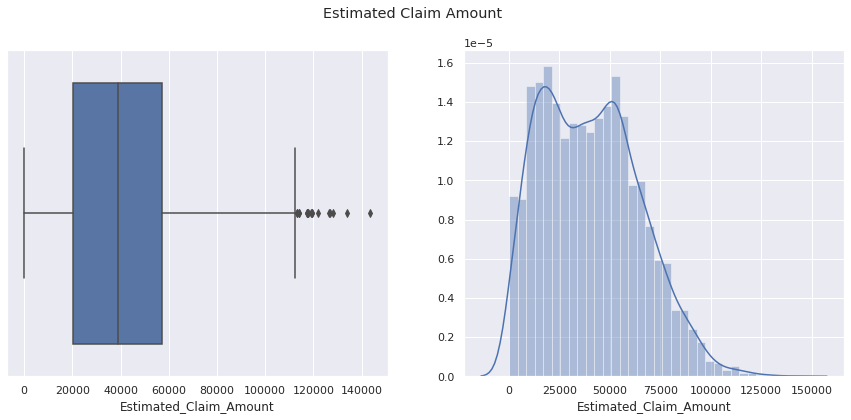

In [10]:
#fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Estimated Claim Amount')

sns.boxplot(x=df_prep[target_column],ax=ax1)
sns.distplot(df_prep[target_column],ax=ax2)
plt.show()

We see that the target variable is skewed and has a high range of values. Hence we will be tranforming the target variable while building regression models.

### Data Prep <a name="dataprep"></a>



#### Correlation Analysis
We carry out a correlation analysis on all variables specified in `numerical_cols`.

From the result of the analysis we can see that some of the columns are highly correlated with each other. We remove the highly correlated variables from the numerical list. They will not be used as input into the model.

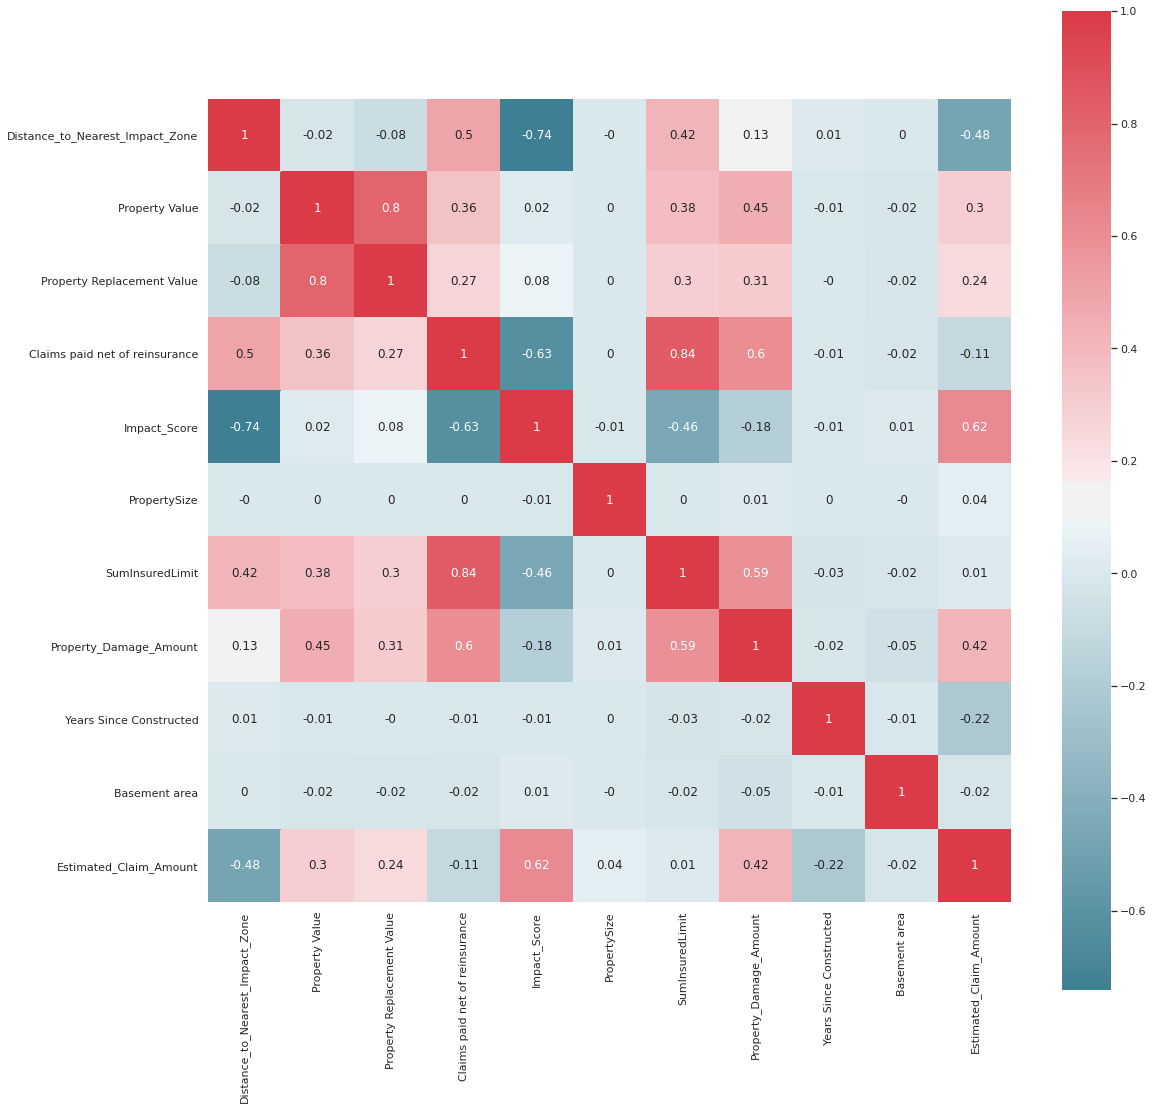

In [11]:
# check correlation between numerical features
f, ax = plt.subplots(figsize=(18, 18))
corr = df_prep[numerical_cols+[target_column]].corr()
corr = corr.round(2)
temp = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
           square=True, ax=ax,annot=True)

In [12]:
corr_cols_to_drop=['Claims paid net of reinsurance']
# Remove the column from the prepped data
df_prep=df_prep.drop(columns=corr_cols_to_drop,axis=1)
# also remove them from the list of numerical features
numerical_cols = [i for i in numerical_cols if i not in corr_cols_to_drop]

# Select only the columns that are used in the column lists specified above
df_prep=df_prep[numerical_cols+categorical_cols+[target_column]]
df_prep.head()

,Distance_to_Nearest_Impact_Zone,Property Value,Property Replacement Value,Impact_Score,PropertySize,SumInsuredLimit,Property_Damage_Amount,Years Since Constructed,Basement area,Previous_claims,Insurance Product,Extended Coverage,Construction material,Construction type,Protection_Class,Estimated_Claim_Amount
16,480.36,272905.38,173985.17,0.00,508,47244.58,48876.88,19,0,1,Commercial risk policy,0,Brick,Wood frame and brick,Flood Protection,6578.59
17,471.15,304404.04,180261.59,0.00,1016,208909.05,165493.17,34,0,0,Specialized home owner,0,Wood,Wood frame and brick,Flood Protection,22673.04
18,461.95,261936.41,199216.26,0.00,610,179763.99,185974.85,28,0,1,Home owners policys,0,Brick,Wood frame and brick,Flood Protection,20980.73
19,452.76,346776.36,266080.45,0.00,203,237988.69,246211.21,21,0,0,Commercial risk policy,0,Steel,Steel frame concrete,Flood Protection,35855.00
20,443.58,277170.66,252223.72,0.00,203,236791.37,244972.53,7,0,1,Commercial risk policy,0,Brick,Wood frame and brick,Flood Protection,37856.88


### Visualise the Input Data
As described we use `plot_scatter_and_boxplot` function to create plots for selected variables. Based on the type of the variable (numerical or categorical), set of scatter plots or boxplots will be displayed.

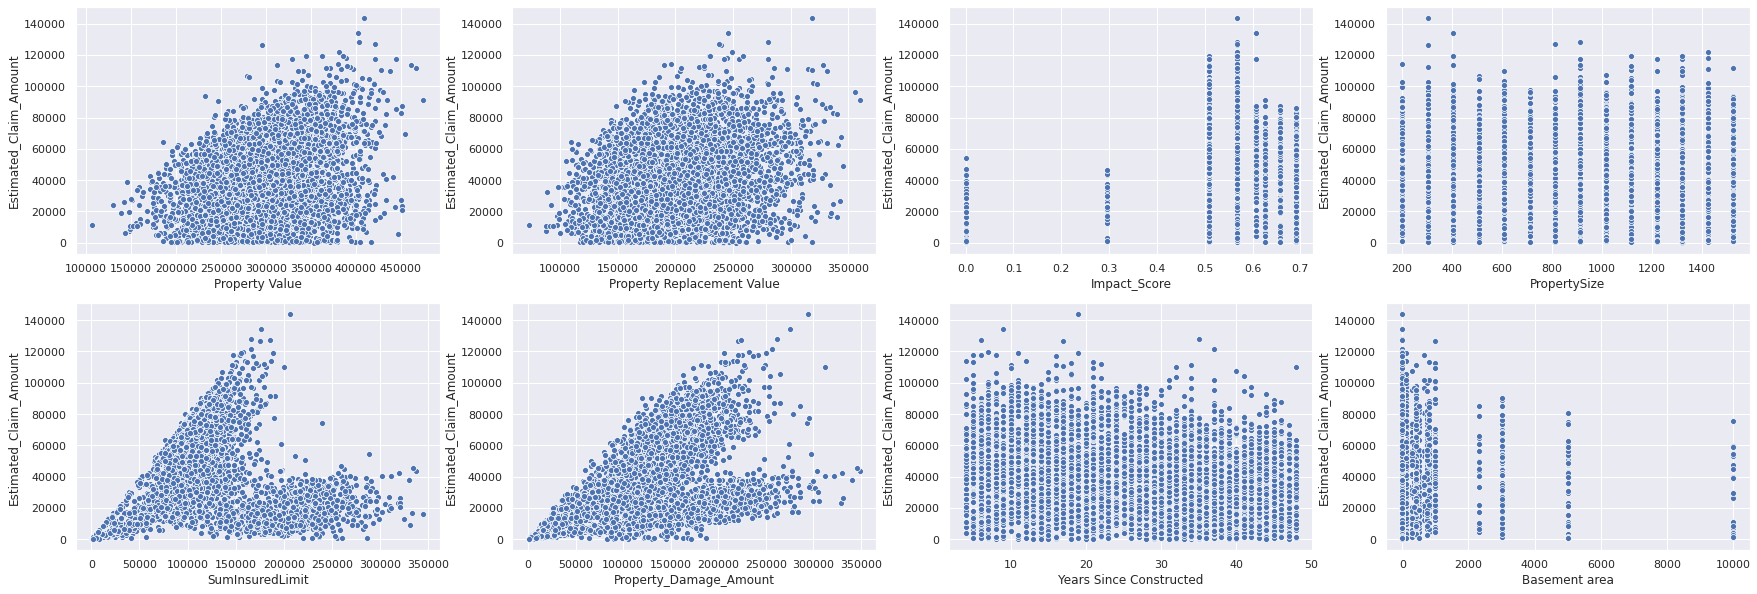

In [13]:
plot_scatter_and_boxplot(df_prep,target_column,"numerical",numerical_cols[1:])

As we can see from the above plots, some of the variables such as Impact Score, Property Value etc. could have a significant impact on the estimated insurance claim. 

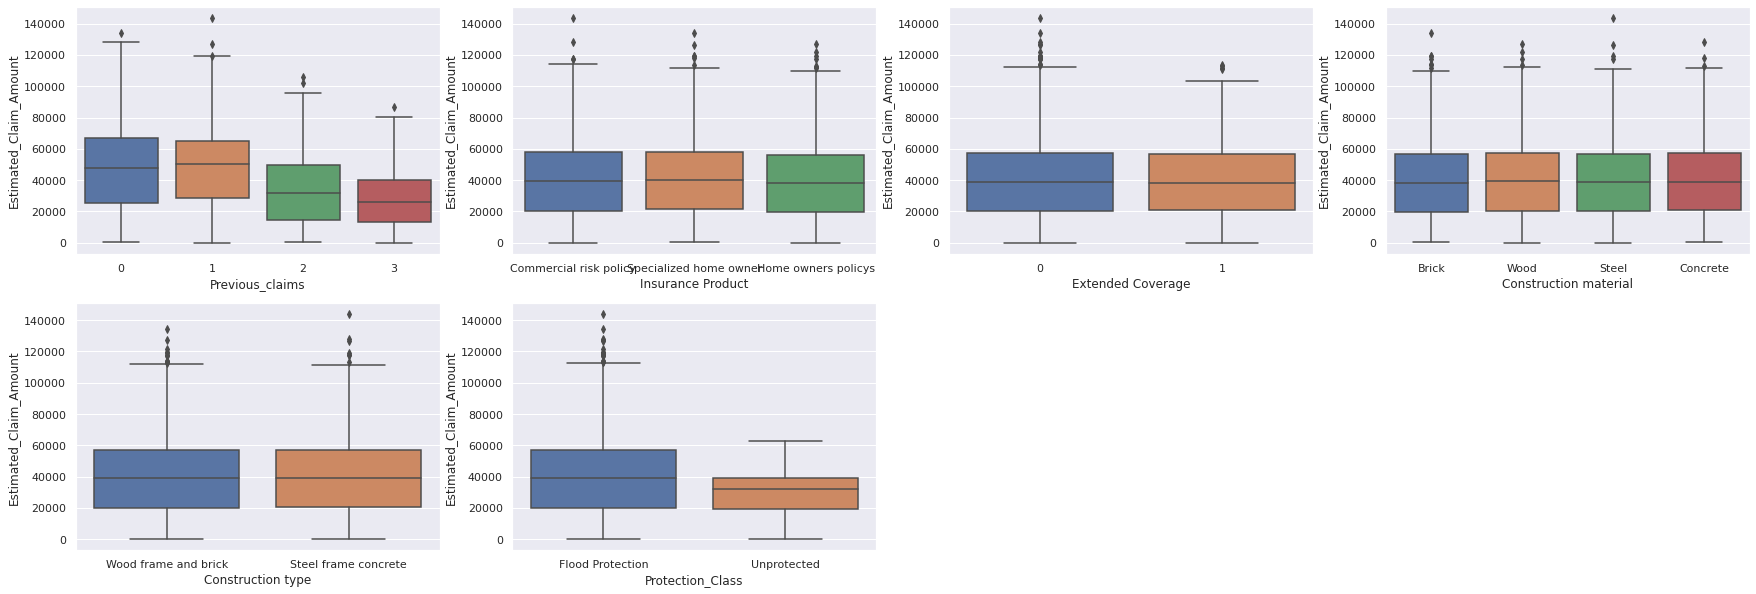

In [14]:
plot_scatter_and_boxplot(df_prep,target_column,"categorical",categorical_cols)

As we can see from the above plots, some of the categorical variables such as Previous claims, Protection Class etc. have a significant impact on the estimated insurance claim. 

### Split Data and Build Transformer  <a name="pipelines"></a>

We split the data into training and test sets. We use 80% of the data for training and the remaining 20% for testing. We build the models on the training set, carry out hyperparameter tuning on the test set and finally apply the selected model to the test set.

We use built-in sklearn transformers to process the data and get it ready for input into the model.

For categorical variables we create a pipeline with 2 steps. We first use the `SimpleImputertransformer` to fill in missing values with 'Other'. Next we use OneHotEncoder to create dummy variables for each category. The transformers are applied to the features specified in the `categorical_cols` variable.

For numerical variables the pipeline has a single step in our example. We again use the `SimpleImputertransformer` to fill in missing values. The transformer is applied to the features specified in the `numerical_cols` variable.

The transformers are combined, and to test it out, we fit and transform them to the training data. We then transform the test data.

Since our target variable has a high range of values and is skewed, We use `TransformedTargetRegressor` in the pipeline to transform the target variable. This transformer uses the `log` function and its inverse `exp`.

In [15]:

X = df_prep.dropna(axis=0, subset=[target_column]).drop([target_column], axis=1)
y = df_prep.dropna(axis=0, subset=[target_column])[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

X_test.head()

,Distance_to_Nearest_Impact_Zone,Property Value,Property Replacement Value,Impact_Score,PropertySize,SumInsuredLimit,Property_Damage_Amount,Years Since Constructed,Basement area,Previous_claims,Insurance Product,Extended Coverage,Construction material,Construction type,Protection_Class
5004,114.83,297209.70,225636.29,0.00,813,87568.47,142655.55,26,502,0,Home owners policys,0,Wood,Wood frame and brick,Flood Protection
1175,165.11,285130.09,192118.64,0.00,1118,33212.38,78066.60,31,100,2,Home owners policys,0,Wood,Wood frame and brick,Flood Protection
2262,0.00,325750.61,223060.21,0.30,914,114777.35,101981.55,25,0,3,Specialized home owner,0,Wood,Wood frame and brick,Flood Protection
5555,0.00,340347.03,278443.52,0.51,203,119869.89,123845.80,25,400,2,Commercial risk policy,0,Brick,Wood frame and brick,Flood Protection
2366,0.00,254856.02,181926.28,0.30,508,100474.96,76679.37,24,0,2,Commercial risk policy,0,Brick,Wood frame and brick,Flood Protection


We don't have any missing data in our dataset but we keep this here for demonstration purposes, as data for scoring may have missing data.

In [16]:
categorical_transformer = Pipeline(steps=[('impute_missing', SimpleImputer(strategy='constant', fill_value='Other')), ('dummy_vars', OneHotEncoder(handle_unknown='ignore'))])
numeric_transformer = Pipeline(steps=[('impute_missing', SimpleImputer(strategy='mean')), ('standardise_vars', MinMaxScaler())])

In [17]:
claim_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
            ],sparse_threshold=0)

fitted_preprocessor = claim_preprocessor.fit(X_train)

X_train_postprocess = fitted_preprocessor.transform(X_train)

X_test_postprocess = fitted_preprocessor.transform(X_test)

In [18]:
onehot_columns=list(fitted_preprocessor.named_transformers_['cat'].named_steps['dummy_vars'].get_feature_names(input_features=categorical_cols))
numeric_features_list = list(numerical_cols)
numeric_features_list.extend(onehot_columns)

### Model Hyperparameter Tuning and Model Selection <a name="tuning"></a>

We selected a random forest model for this example. We do some hyperparameter tuning and select the final hyperparameters based on the best RMSE on the test set. We use `TransformedTargetRegressor` to tranform the target variable while fitting the model.

In [19]:
l_ne = [100, 150]
l_md = [7, 10,12] 
l_mf = [0.75, 0.9]


highest_rmse = 10000000.0
top_ne = 0
top_md = 0
top_mf = 0.0

for ne in l_ne:
    for md in l_md:
        for mf in l_mf:
            reg = TransformedTargetRegressor(RandomForestRegressor(n_estimators=ne, max_depth=md, max_features=mf, random_state=0,oob_score=True), func=np.log1p,  inverse_func=np.expm1)
            reg.fit(X_train_postprocess, y_train)
            y_pred = reg.predict(X_test_postprocess)
            rmse=np.sqrt(metrics.mean_squared_error(y_test, y_pred))
            r2 = metrics.r2_score(y_test, y_pred)
            
            if rmse< highest_rmse:
                print("Estimators:"+str(ne)+", max_depth:"+str(md) +", max features:"+str(mf))
                print('Mean Absolute Error:'+ str(metrics.mean_absolute_error(y_test, y_pred)) + ' Mean Squared Error:'+ str(metrics.mean_squared_error(y_test, y_pred)) +' Root Mean Squared Error:' + str(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))+" R Squared: " +str(r2)  +"**")            
                top_ne = ne
                top_md = md
                top_mf = mf
                highest_rmse = rmse
            else:
                print("Estimators:"+str(ne)+", max_depth:"+str(md) +", max features:"+str(mf))
                print('Mean Absolute Error:'+ str(metrics.mean_absolute_error(y_test, y_pred)) + ' Mean Squared Error:'+ str(metrics.mean_squared_error(y_test, y_pred)) +' Root Mean Squared Error:' + str(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))+" R Squared: " +str(r2)) 

Estimators:100, max_depth:7, max features:0.75
Mean Absolute Error:4619.146185648382 Mean Squared Error:49142895.78075878 Root Mean Squared Error:7010.199410912559 R Squared: 0.9172500994951662**
Estimators:100, max_depth:7, max features:0.9
Mean Absolute Error:4625.819803049968 Mean Squared Error:48946172.44163542 Root Mean Squared Error:6996.154117916173 R Squared: 0.917581354633489**
Estimators:100, max_depth:10, max features:0.75
Mean Absolute Error:2823.665175108328 Mean Squared Error:19414664.958850197 Root Mean Squared Error:4406.2075483175095 R Squared: 0.9673083653668499**
Estimators:100, max_depth:10, max features:0.9
Mean Absolute Error:2791.740358187425 Mean Squared Error:18876393.84588285 Root Mean Squared Error:4344.697209919565 R Squared: 0.9682147401405586**
Estimators:100, max_depth:12, max features:0.75
Mean Absolute Error:2504.506010525878 Mean Squared Error:15599242.18324456 Root Mean Squared Error:3949.587596603544 R Squared: 0.9737330143430477**
Estimators:100, ma

### Build Final Model and Pipeline

Next we create a pipeline which combines the preprocessing steps of prepping the data and building the model with the selected hyperparameters. 

With this pipeline we can pass data in in its raw form, with missing values and categorical data. Missing data is replaced and dummy variables are created. This prepped data is then passed to the model pipeline. Model pipeline is built using `TransformedTargetRegressor` with `log` and `inverse` functions on the target variable. This pipeline is used to fit the training data and to predict the model results on test data.

In [20]:

pipeline = Pipeline(steps=[('preprocessor', claim_preprocessor),
                      ('model', RandomForestRegressor(n_estimators=top_ne, max_depth=top_md, max_features=top_mf, random_state=0,oob_score=True))])


model_pipeline = TransformedTargetRegressor(pipeline,  func=np.log1p, inverse_func=np.expm1)

model_pipeline.fit(X_train, y_train)


y_pred_train=model_pipeline.predict(X_train)
y_pred_test=model_pipeline.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_test))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_test))
print('Root Mean Squared Error Train:',mean_squared_error(y_pred_train,y_train, squared=False))
print('Root Mean Squared Error Test:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
r2=metrics.r2_score(y_test, y_pred_test)
print("R Squared",r2)
print("OOB SCORE",model_pipeline.regressor_.named_steps['model'].oob_score_)


Mean Absolute Error: 2457.256324970685
Mean Squared Error: 15019616.269428186
Root Mean Squared Error Train: 2305.3116116563037
Root Mean Squared Error Test: 3875.5149682884967
R Squared 0.9747090249329061
OOB SCORE 0.9847344666963233


### View Model Results <a name="results"></a>

First we'll look at the plots of the Actual vs Predicted target variable and Residuals. We use Root mean squared error and R squared as the model evaluation metrics.
Actual vs Predicted is a plot of the actual target values vs the predicted outcomes in the test data. 

Text(100000, -20000, 'RMSE=3875.5')

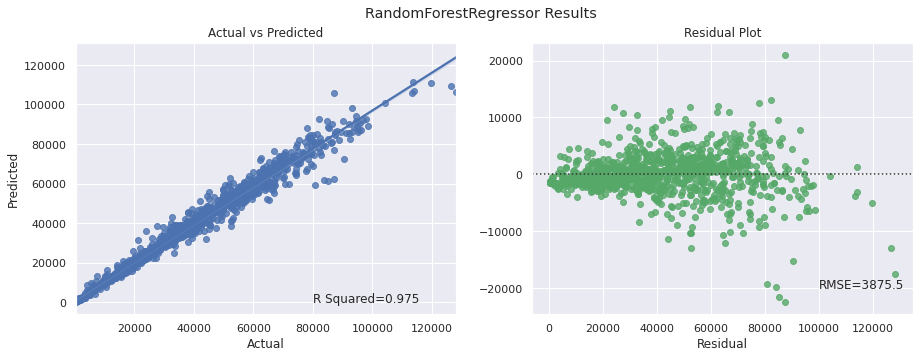

In [21]:

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False)
fig.suptitle('RandomForestRegressor Results')

# Scatter plot for Actual vs Predicted
sns.regplot(x=y_test, y=y_pred_test,ax=axes[0],fit_reg=True)
axes[0].set_title("Actual vs Predicted")
axes[0].set_ylabel('Predicted')
axes[0].set_xlabel('Actual')
axes[0].text(80000, 0, "R Squared="+str(round(r2,3)))

# residplot for plotting residuals
sns.residplot(x=y_test, y=y_pred_test,ax=axes[1],  color="g")
axes[1].set_title("Residual Plot")
axes[1].set_xlabel('Residual')
axes[1].text(100000, -20000, "RMSE="+str(round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)),1)))

As we see from the above plots, the regression model did a good job predicting estimated insurance claim amount. The actual and predicted values are closely aligned and residuals are around 0 with fewer outliers.

### Feature Importance of the model
With tree based models we can view variable importance plots. These plots indicate, at the feature level, some importance for the variable in classifying the outcome variable. They use gini importance (mean decrease in impurity) which looks at node impurity. Node impurity is just looking at how well a tree splits the data. Technically it calculates each feature importance as the sum over the number of splits that include the feature, proportionally to the number of samples it splits.

We'll take a look at the feature importance plots for the random forest models.

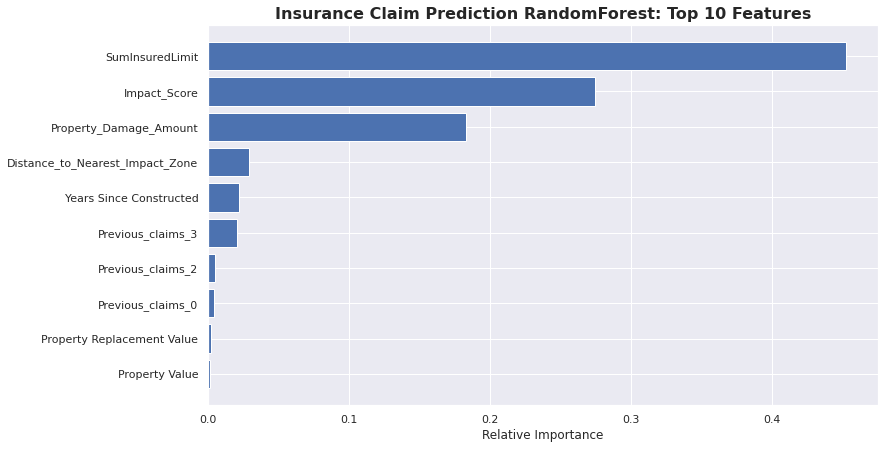

In [22]:
plot_feature_importance(feature_list=numeric_features_list, 
                        feature_importances=model_pipeline.regressor_.named_steps['model'].feature_importances_, 
                        title="Insurance Claim Prediction RandomForest: Top 10 Features")

The chart indicates, at the feature level, some importance for the variable in predicting the outcome variable. Impact Score, Sum Insured Limit and Insurance Claim Amount along with previous claims are important features in predicting the Estimated Claim Amount.

### Save Data for RShiny Dashboard
We save the data out for use in the RShiny dashboard. We score the `df_raw` dataframe and save the dataframe and scores out. This data contains records for all the properties.

In [23]:
fields=X_train.columns.tolist()
df_model_results=df_raw[(df_raw['within_impacted_zones']==True)| (df_raw["Distance_to_Nearest_Impact_Zone"]<500)].copy()


df_model_results['Estimated_Claim_Amount_Predicted']=model_pipeline.predict(df_model_results[fields])
df_model_results["Model_Results"]="YES"


df_unused = df_raw[df_raw["Distance_to_Nearest_Impact_Zone"]>=500].copy()
df_unused['Estimated_Claim_Amount_Predicted']=0
df_unused["Model_Results"]="NO"

df_save_out = df_model_results.append(df_unused)
project.save_data('model_output_summary.csv', df_save_out.to_csv(index=False), overwrite=True)

{'file_name': 'model_output_summary.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'insurancelossestimationusingremot-donotdelete-pr-tex9yjwvam6vkk',
 'asset_id': '33036e5f-0ef9-403f-913e-cae87da417f1'}

## Save the Model to Cloud Pak for Data


In the next steps we save and deploy the model.

Before we save the model we must create a deployment space. Watson Machine Learning provides deployment spaces where the user can save, configure and deploy their models. We can save models, functions and data assets in this space.


If you do not have a space, you can use the Deployment Spaces Dashboard to create one:

1  Navigate to Deployments
2  Click New Deployment Space
3  Enter Deployment space name
4  Select Cloud Object Storage
5  Select Watson Machine Learning instance and press Create
6  Copy the space name and paste it below 

The steps involved in saving and deploying the model are detailed in the following cells. We will use the [ibm-watson-machine-learning](http://ibm-wml-api-pyclient.mybluemix.net) package to complete these steps.

### User Inputs
The user can specify the name for the space, models and model deployments. 

In [24]:
# Specify a name for the space being created, the saved model and the model deployment
space_name = 'Insurance Loss Estimation Using Remote Sensing Space'
model_name = 'Insurance Loss Estimation Using Remote Sensing Model'
deployment_name = 'Insurance Loss Estimation Using Remote Sensing Model Deployment'



In [25]:
from ibm_watson_machine_learning import APIClient


if ibmcloud_api_key != '':
    wml_credentials = {
        "apikey": ibmcloud_api_key,
        "url": 'https://' + os.environ['RUNTIME_ENV_REGION'] + '.ml.cloud.ibm.com'
    }
else:
    token = os.environ['USER_ACCESS_TOKEN']
    wml_credentials = {
        "token": token,
        "instance_id" : "openshift",
        "url": os.environ['RUNTIME_ENV_APSX_URL'],
        "version": "3.5"
     }
client = APIClient(wml_credentials)

### Select the Deployment Space

By default, if the space name already exists, the existing space will be used to store and deploy models and functions.

In [26]:
space_uid=""
for space in client.spaces.get_details()['resources']:

    if space['entity']['name'] ==space_name:
        print("Deployment space with ",space_name," exists . .")
        space_uid=space['metadata']['id']
        client.set.default_space(space_uid)
        print("Using the existing space")
            
            
if space_uid=="":
    if ibmcloud_api_key == '':
        # create the space and set it as default
        space_meta_data = {
            client.spaces.ConfigurationMetaNames.NAME : space_name

            }

        stored_space_details = client.spaces.store(space_meta_data)

        space_uid = stored_space_details['metadata']['id']

        client.set.default_space(space_uid)
    
    else:
        print("Deployment space",space_name, "doesn't exist, Please create a new deployment space before continue..")
        raise Exception("Deployment space doesn't exist")

Deployment space with  Insurance Loss Estimation Using Remote Sensing Space  exists . .
Using the existing space


Store the Model Details
Store the model in the deployment space. The name for the model is specified in the user inputs cell above. Software specification, default tag and input data schema for the model are specified in the model metadata. Example to create a metatadata can be viewed using `client.repository.ModelMetaNames.get_example_values()`.
The Software Specification refers to the runtime used in the Notebook, WML training and WML deployment. We use the software specification `default_py3.7` to store the models. We get the ID of the software specification and include it in the metadata when storing the model. Available Software specifications can be retrieved using `client.software_specifications.list()`.

In [27]:
sw_spec_uid = client.software_specifications.get_uid_by_name("default_py3.7")

metadata = {
    client.repository.ModelMetaNames.NAME: model_name,
    client.repository.ModelMetaNames.INPUT_DATA_SCHEMA:[{'id': '1', 'type': 'struct', 'fields': [{"name":column_name,"type":str(column_type[0])} for column_name,column_type in pd.DataFrame(X_train.dtypes).T.to_dict('list').items()]}],
    client.repository.ModelMetaNames.TYPE: "scikit-learn_0.23",
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: sw_spec_uid 
}

stored_model_details = client.repository.store_model(model=model_pipeline, meta_props=metadata)
stored_model_details

{'entity': {'schemas': {'input': [{'fields': [{'name': 'Distance_to_Nearest_Impact_Zone',
       'type': 'float64'},
      {'name': 'Property Value', 'type': 'float64'},
      {'name': 'Property Replacement Value', 'type': 'float64'},
      {'name': 'Impact_Score', 'type': 'float64'},
      {'name': 'PropertySize', 'type': 'int64'},
      {'name': 'SumInsuredLimit', 'type': 'float64'},
      {'name': 'Property_Damage_Amount', 'type': 'float64'},
      {'name': 'Years Since Constructed', 'type': 'int64'},
      {'name': 'Basement area', 'type': 'int64'},
      {'name': 'Previous_claims', 'type': 'int64'},
      {'name': 'Insurance Product', 'type': 'object'},
      {'name': 'Extended Coverage', 'type': 'int64'},
      {'name': 'Construction material', 'type': 'object'},
      {'name': 'Construction type', 'type': 'object'},
      {'name': 'Protection_Class', 'type': 'object'}],
     'id': '1',
     'type': 'struct'}],
   'output': []},
  'software_spec': {'id': 'e4429883-c883-42b6-87a8-

### Deploy the Model <a name="savemodel"></a>

Deploy the saved model. The deployment name is specified in the user inputs cell above. Again, a default tag for the deployment is specified in the deployment metadata.



In [28]:
# create meta-props for the model
meta_props = {
    client.deployments.ConfigurationMetaNames.NAME: deployment_name,
    client.deployments.ConfigurationMetaNames.TAGS : ['Remote Sensing Tag'],
    client.deployments.ConfigurationMetaNames.ONLINE: {},
    client.deployments.ConfigurationMetaNames.CUSTOM: fields
}

# deploy the model

model_uid = stored_model_details["metadata"]["id"]
deployment_details = client.deployments.create( artifact_uid=model_uid, meta_props=meta_props)



#######################################################################################

Synchronous deployment creation for uid: 'b4a1807c-d7ae-45cc-a528-a23825a653e6' started

#######################################################################################


initializing
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='4fbc2564-32b1-430e-8f37-15c2678fef52'
------------------------------------------------------------------------------------------------




### Sample Scoring <a name="samplescoring"></a>

The above model deployment can be tested by sending sample payload as input data. The below cell selects sample property ids from the raw data to predict estimated claim amount.

In [29]:
#Get the deployment id for the deployed model
deployment_uid=client.deployments.get_uid(deployment_details)

# Select sample customer ids to score
property_IDS=[1101,1102,1103,1104,1105]
# Filter these customers records from df_raw
df_score=df_raw[df_raw['PropertyId'].isin(property_IDS)]

In [30]:
# Create a payload with fields and values dictionary

values=df_score[fields].values.tolist()
payload_scoring={"input_data": [{"fields": fields,"values": values}]}


#payload = {
#    client.deployments.ScoringMetaNames.INPUT_DATA: [payload_scoring]
#}

# Pass the payload to wml client to predict attrition_status for the sample records
scoring_response = client.deployments.score(deployment_uid, payload_scoring)
scoring_response

{'predictions': [{'fields': ['prediction'],
   'values': [[62280.43554501557],
    [45306.751219665544],
    [47982.18404615444],
    [15152.896391798793],
    [23960.83894946403]]}]}

**Follow the instructions from Readme to launch R-Shiny Dashboard**

<hr>

Sample Materials, provided under <a href="https://github.com/IBM/Industry-Accelerators/blob/master/CPD%20SaaS/LICENSE" target="_blank" rel="noopener noreferrer">license</a>. <br>
Licensed Materials - Property of IBM. <br>
© Copyright IBM Corp. 2020, 2021. All Rights Reserved. <br>
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp. <br>